In [ ]:
# analyseInterestingStars.ipynb
#
# Author: Alexander J Mustill, 2018
# Lund Observatory, Department of Astronomy & Theoretical Physics, 
# Lund University, Box 43, SE-221 00 Lund, Sweden
#
# If you make use of this code, please cite Mustill, Davies & Lindegren (2018, A&A submitted).
#
# Please direct any queries to Alexander Mustill, alex@astro.lu.se
#
# This queries the Gaia archive for background sources to the list of "interesting" stars and 
# picks out source--lens pairs that approach within 0.1 arcsec, accounting for nominal parallax and proper motion.

In [1]:
import datetime
import math

import astropy.units as u
import numpy as np

from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astropy.io.votable import parse_single_table
from astropy.io import ascii
from astropy.table import vstack

from gaiaDR2 import Gaia

from matplotlib import pyplot as plt

from microlensing import  magnification, REinstein, get_alignments

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
vot_file = ['100pc_'+str(i).zfill(3)+'.vot' for i in range(360)]
Earth = ascii.read("EarthEphemerisNt8000.txt",format="csv",fast_reader=False,
                   header_start=20,data_start=23,data_end=8024)
nt = 8001

In [3]:
tmp = []
for i in range(len(vot_file)):
    tmp.append(parse_single_table(vot_file[i]).to_table())

s = vstack(tmp)


In [4]:
deltaT = 20 #time we're interested in [yr]

Nclose = np.zeros(len(s)) #number of neighbours within search radius (INCLUDING SELF)
radius = []
results = []

In [5]:
interesting = np.array([2610, 4862, 5565, 6087, 18812, 20762, 23900, 25237, 25381, 26772, 29865, 30019, 33391, 36762, 40759, 43686, 46021, 51430, 59286, 63138, 72490, 73029, 73764, 76083, 77750, 78921, 81307, 82538, 82580, 85919, 86194, 88423, 92001, 95377, 97244, 97829, 100919, 102950, 108599, 109302, 109312, 109355, 110098, 111133, 112938, 112968, 116762, 122072, 122121, 129273, 137280, 137584, 139383, 140403, 149167, 151232, 152847, 153585, 153653, 154616, 154971, 158867, 160354, 161040, 163445, 164301, 164630, 165775, 166581, 167411, 168188, 168564, 168822, 170615, 171688, 176401, 178826, 178876, 178953, 183178, 189701, 192222, 199517, 199882, 203524, 207844, 212116, 216785, 220528, 221328, 221654, 222105, 226301, 226346, 235622, 246229, 246756, 247353, 250319, 253322, 254744, 254892, 255283, 258136, 259309, 264302, 266940, 267600, 268072, 275857, 276120, 276202, 276721, 277821, 279461, 281189, 282025, 282184, 284151, 287144, 287221, 292219, 293251, 293704, 294720, 295157, 304622, 307737, 307901, 308740, 309909, 319438, 325297, 326382, 327741, 329243, 331348, 331548, 334679, 340935, 341482, 343357, 347500, 356152, 357953, 361815, 365222, 367260, 369601, 372478, 373725, 378100, 379500, 379686, 380645, 383663, 383712, 386571, 388268, 398221, 402316, 405739, 407214, 411719, 413576, 417052, 419122, 420447, 431695, 440314, 441912, 447529, 451921, 452660, 455166, 460489, 461777, 467897, 470485, 480564, 484234, 486079, 488502, 500762, 506228, 509126, 509185, 509947, 513297, 515097, 516044, 518467, 519324, 529950, 534377, 536918, 539336, 540544, 541014, 541582, 548949, 549113, 555464, 558936, 558947, 559211, 560181, 563198, 565416, 569988, 571016, 574579, 580264, 580892, 589565, 590356, 593507, 594424, 599143, 604468, 604605, 605592, 609975, 611158, 612744, 614057, 615275, 616468, 620259, 624225, 625142, 625554, 625698, 625993, 626564, 627661, 628265, 632574, 634709, 637055, 639012, 639219, 640237, 640845, 642210, 643169, 643630, 644745, 646196, 646770, 650292, 650998, 651042, 654221, 655518, 657255, 661305, 661419, 663572, 665434, 668927, 671213, 671742, 673092, 677244, 686212, 687770, 700053])

In [6]:
#define some quality flags

ast_good = [False]*len(s)
phot_good = [False]*len(s)

for i in range(len(s)):
    ast_good[i] = (np.sqrt(s['astrometric_chi2_al'][i]/(s['astrometric_n_good_obs_al'][i]-5)) 
                   < 1.2*max([1,np.exp(-0.2*(s['phot_g_mean_mag'][i]-19.5))]))
    phot_good[i] = ((s['phot_bp_rp_excess_factor'][i] > 1.0 + 0.015*(s['phot_bp_mean_mag'][i]-
                                                                     s['phot_rp_mean_mag'][i])**2) and 
                   (s['phot_bp_rp_excess_factor'][i] < 1.0 + 0.06*(s['phot_bp_mean_mag'][i]-
                                                                   s['phot_rp_mean_mag'][i])**2))
#print(ast_good)
#print(phot_good)
#print(s['phot_bp_rp_excess_factor'])

In [7]:
t1 = datetime.datetime.now()

#for i in range(len(s)):
start = 0

for i in range(len(s))[start:]:

#    uncomment the following if you have pre-generated the list of interesting stars
    if i in interesting:
#    uncomment the following if you want to check everything (eg first time on dataset)
#    if True:
#    uncomment the following to only allow objects passing the astrometric and photometric vetting
#    if ast_good[i] and phot_good[i]:
        

#compute total PM (cos delta conversion is already performed in the datafiles)
        pm = np.sqrt(s[i]['pmra']**2 + s[i]['pmdec']**2) / (1000*3600) # deg/yr

#search radius = annual parallactic motion plus PM over timescale of interest
        rad = Quantity(pm*deltaT + 2*s[i]['parallax']/(1000*3600),unit=u.deg)
        print('i = ',i)
        job = Gaia.launch_job_async("SELECT DISTANCE(POINT('ICRS',ra,dec), \
        POINT('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+")) AS dist, * \
        FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),\
        CIRCLE('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+","+str(rad.value)+"))=1 ORDER BY dist ASC")
        r = job.get_results()
    
        Nclose[i] = len(r)
        
        radius.append(rad)
        results.append(r)
    else:
        Nclose[i] = 1
        radius.append(None)
        results.append(None)
    
t2 = datetime.datetime.now()

print('Time elapsed: ',t2-t1)

i =  2610
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',2.8749801986941437,59.139388625387824)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',2.8749801986941437,59.139388625387824,0.008265631404714468))=1 ORDER BY dist ASC'
Retrieving async. results...


Query finished.
i =  4862
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',4.392262090640366,64.50752951982356)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',4.392262090640366,64.50752951982356,0.000947874999579649))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  5565
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',5.06389838601928,-26.61844131316427)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',5.06389838601928,-26.61844131316427,0.0006830947896009943))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  6087
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',6.190756487680579,59.75100775499353)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',6.190756487680579,59.75100775499353,0.00070530693322982

Query finished.
i =  78921
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',82.22436623253903,-66.58763971937763)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',82.22436623253903,-66.58763971937763,0.0019748315831497254))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  81307
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',85.54742343791474,12.48257790281952)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',85.54742343791474,12.48257790281952,0.014210863805333951))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  82538
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',86.32623158271936,-63.062876843418266)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',86.32623158271936,-63.062876843418266,0.00263569

Query finished.
i =  129273
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',122.45389269221901,-57.76565910647063)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',122.45389269221901,-57.76565910647063,0.0009390064086757653))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  137280
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',128.76914261678743,-41.7705009366861)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',128.76914261678743,-41.7705009366861,0.0008357770546194005))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  137584
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',129.4719485764638,-21.651617743476884)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',129.4719485764638,-21.651617743476884,0.

Query finished.
i =  168822
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',161.08537541572895,-61.20286201386087)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',161.08537541572895,-61.20286201386087,0.009265893252538241))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  170615
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',162.8630351340534,-56.60045972709581)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',162.8630351340534,-56.60045972709581,0.0008767319394841274))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  171688
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',163.28340981727723,-69.4415211763089)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',163.28340981727723,-69.4415211763089,0.001

Query finished.
i =  246229
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',211.6510722302152,-12.06143195597905)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',211.6510722302152,-12.06143195597905,0.0014215905062260582))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  246756
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',211.55293132604533,-69.95496242413797)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',211.55293132604533,-69.95496242413797,0.0008678305433272998))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  247353
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',212.92720186248638,-45.405533992605164)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',212.92720186248638,-45.405533992605164,

Query finished.
i =  284151
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',234.14184898855942,-37.9098286758601)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',234.14184898855942,-37.9098286758601,0.004892619548146088))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  287144
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',235.5561875575584,-28.816176428520965)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',235.5561875575584,-28.816176428520965,0.0013588809032983873))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  287221
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',235.19474711062668,-51.02805617318089)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',235.19474711062668,-51.02805617318089,0.0

Query finished.
i =  343357
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',252.93736999248145,-39.923695119279834)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',252.93736999248145,-39.923695119279834,0.0012862620546083535))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  347500
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',253.14588693518522,-29.006807206864224)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',253.14588693518522,-29.006807206864224,0.002063701311117229))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  356152
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',255.1158024759729,-22.127737517125297)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',255.1158024759729,-22.1277375171252

Query finished.
i =  413576
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',265.14124561435915,-64.32651502577049)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',265.14124561435915,-64.32651502577049,0.0014135467990712134))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  417052
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',265.2296875629242,-13.651562222831016)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',265.2296875629242,-13.651562222831016,0.000946809601414353))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  419122
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',266.31502964549554,-47.37796780203548)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',266.31502964549554,-47.37796780203548,0

Query finished.
i =  509947
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',279.2438570859401,-35.12260460117022)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',279.2438570859401,-35.12260460117022,0.0015023321133204352))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  513297
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',280.29355955729943,-13.448724411422319)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',280.29355955729943,-13.448724411422319,0.0007949020255101499))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  515097
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',280.62060068065455,-6.955436345384621)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',280.62060068065455,-6.955436345384621,

Query finished.
i =  571016
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',292.42658380508044,-18.69697202689536)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',292.42658380508044,-18.69697202689536,0.0013769117390886184))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  574579
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',293.0439581359414,40.52191545656917)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',293.0439581359414,40.52191545656917,0.0010167583755381585))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  580264
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',293.2303104780642,-12.07189250730852)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',293.2303104780642,-12.07189250730852,0.0017

Query finished.
i =  626564
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',300.8629199379491,23.607843660423896)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',300.8629199379491,23.607843660423896,0.0004850190814761741))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  627661
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',300.682207569225,25.417534518374534)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',300.682207569225,25.417534518374534,0.00184777580951687))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  628265
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',301.52475415816986,-31.56479781031698)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',301.52475415816986,-31.56479781031698,0.003714

Query finished.
i =  663572
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',322.8411078799011,54.441365797408295)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',322.8411078799011,54.441365797408295,0.0018879533793292227))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  665434
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',324.09201295011314,31.98673847772375)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',324.09201295011314,31.98673847772375,0.0010103245815094159))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
i =  668927
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',328.72060408603875,49.346035771795094)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',328.72060408603875,49.346035771795094,0.00

In [8]:
print(sum([i > 1 for i in Nclose]))


for i in range(len(s))[start:]:

    if Nclose[i] > 1:
    
        print('i = ',i,' Gaia DR2 ID: ',s[i]['source_id'],' at RA = ',s[i]['ra'],
              ' Dec = ',s[i]['dec'])
        print('Search radius: ',radius[i-start].to(u.arcsec))
        results[i-start]['dist','source_id','ra','dec'].pprint(max_width=-1,max_lines=-1)
        print('----------------------------------------------------------------------------------------------')
        print('')

268
i =  2610  Gaia DR2 ID:  423027104407576576  at RA =  2.8749801986941437  Dec =  59.139388625387824
Search radius:  29.756273056972084 arcsec
         dist             source_id              ra                dec        
                                                deg                deg        
--------------------- ------------------ ------------------ ------------------
                  0.0 423027104407576576 2.8749801986941437 59.139388625387824
0.0008725514389427787 423027100104524416  2.874992535013451  59.13851609689552
0.0037263053197496526 423027104399103104  2.875395345314068 59.135668410512764
 0.003949610901988486 423028577573277824  2.882242227303801  59.14070157517923
 0.004621551965207432 423028581867839104 2.8830748653546423  59.14141822003081
 0.006901303374408478 423028581876323328 2.8764109405025358  59.14625080331109
 0.006919884266685125 423027104399103232 2.8663276024940956  59.13407988688522
 0.007423899662768694 423028581871666176 2.8846802660573134  59.

----------------------------------------------------------------------------------------------

i =  152847  Gaia DR2 ID:  1131732854684056192  at RA =  144.77962768572678  Dec =  78.35526390037715
Search radius:  19.977223720223964 arcsec
         dist              source_id              ra                dec       
                                                 deg                deg       
--------------------- ------------------- ------------------ -----------------
                  0.0 1131732854684056192 144.77962768572678 78.35526390037715
0.0033058964799362552 1131732850388480512 144.76761763760405 78.35301637387134
----------------------------------------------------------------------------------------------

i =  153585  Gaia DR2 ID:  5408876517460832512  at RA =  145.5040599284424  Dec =  -50.59903172619697
Search radius:  5.0077024375418855 arcsec
        dist              source_id              ra                dec        
                                              

Search radius:  8.740944156197246 arcsec
         dist              source_id              ra                dec        
                                                 deg                deg        
--------------------- ------------------- ------------------ ------------------
                  0.0 5859036609689409280 197.99940875659328 -64.39064312759518
0.0006043281841184873 5859036609640221824  197.9986038289379 -64.39014899743354
0.0011305292135947356 5859036609640217472  198.0019868214555 -64.39083387679145
0.0016490649605271203 5859036678359699456  197.9959026840438 -64.38999289572105
0.0019741558425170804 5859036609641622656 198.00290783280926  -64.3919119829745
----------------------------------------------------------------------------------------------

i =  222105  Gaia DR2 ID:  3715886755380790272  at RA =  198.99110734037114  Dec =  4.035150249116307
Search radius:  6.296271525546658 arcsec
         dist              source_id              ra                dec       
 

i =  267600  Gaia DR2 ID:  5903487940560263936  at RA =  225.75137147799427  Dec =  -47.882258895920074
Search radius:  2.7434925374648795 arcsec
         dist              source_id              ra                 dec        
                                                 deg                 deg        
--------------------- ------------------- ------------------ -------------------
                  0.0 5903487940560263936 225.75137147799427 -47.882258895920074
 0.000394510691136775 5903487940560263808  225.7507833879248  -47.88226797116563
0.0005601140803689885 5903487940560264064 225.75102733418709 -47.882769247408156
----------------------------------------------------------------------------------------------

i =  268072  Gaia DR2 ID:  5800510224109658240  at RA =  225.01439799786235  Dec =  -67.55583357057081
Search radius:  3.0653733056520394 arcsec
         dist              source_id              ra                dec        
                                               

i =  347500  Gaia DR2 ID:  6032685745182407040  at RA =  253.14588693518522  Dec =  -29.006807206864224
Search radius:  7.4293247200220245 arcsec
         dist              source_id              ra                 dec        
                                                 deg                 deg        
--------------------- ------------------- ------------------ -------------------
                  0.0 6032685745182407040 253.14588693518522 -29.006807206864224
0.0004445848561772221 6032685745164337152 253.14581849820482 -29.006366669271557
0.0005885644240044506 6032685745164337280  253.1458341468001 -29.007393957856703
0.0015569473256287754 6032685745164338816  253.1475728234248  -29.00630702897448
0.0017370109130682104 6032685745164349184   253.145385149649 -29.005126545999893
0.0018039695108624922 6032685745166265088 253.14414811402446 -29.007777659163207
0.0020229694400755965 6032685745182405760 253.14512129188932  -29.00871614530828
--------------------------------------------

 0.002358333241316323 4043052483364905472 271.24029504876466 -32.006702841565925
0.0024098282016773464 4043052483365046272 271.24327936532825 -32.006610711392945
 0.002775538454104361 4043052487569780864  271.2391520615844 -32.010288733656886
 0.002810038328310026 4043052483252494592 271.24081939701625  -32.00599710404898
0.0028792218216675512 4043052418899313280  271.2435350281682  -32.01116018968042
0.0029707420373163264 4043052483365046784 271.24344412655995  -32.00604609840844
0.0030144939936035094 4043052487619782656  271.2453706686131 -32.008749081744455
  0.00320944130350598 4043052483364953088  271.2407475196217 -32.005598146102585
0.0032532626479616312 4043052105407829888  271.2395554708098   -32.0113049999582
0.0032626078113573882 4043052483364955776  271.2441611266359  -32.00608988221381
0.0032786767387050974 4043052483364907008 271.24490591458033 -32.006705153810266
0.0033398533606283413 4043052418899311232  271.2430550062002  -32.01184736468257
  0.00339449001435064 404305

         dist              source_id              ra                dec        
                                                 deg                deg        
--------------------- ------------------- ------------------ ------------------
                  0.0 1821168701656184064 297.89724875393154 17.348340842768756
0.0004583325942446881 1821168701624317312  297.8971854959386 17.347886504821695
0.0010260503400200721 1821168701656183936  297.8981801280741 17.347828547669543
----------------------------------------------------------------------------------------------

i =  609975  Gaia DR2 ID:  2080285727861817088  at RA =  297.78998165201807  Dec =  46.484536733812874
Search radius:  6.627996789773122 arcsec
        dist              source_id              ra                dec        
                                                deg                deg        
-------------------- ------------------- ------------------ ------------------
                 0.0 2080285727861817088 29

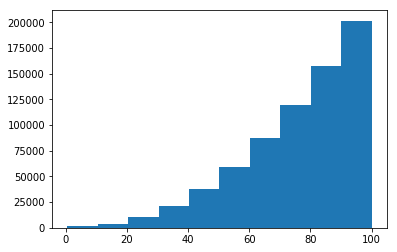

In [9]:
plt.hist(1000.0/s['parallax'])

plt.show()

In [10]:
index = [np.where(Nclose == i) for i in range(int(max(Nclose)+1))]
[len(index[i][0]) for i in range(int(max(Nclose)+1))]

[0,
 699787,
 142,
 36,
 22,
 12,
 11,
 10,
 2,
 5,
 2,
 4,
 1,
 3,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [11]:
len([i for i in range(len(s)) if Nclose[i] > 1])

268

In [12]:
theta_E = 1.0 *u.mas * np.sqrt(s['parallax']/0.125)
r_E = theta_E * (1000/(s['parallax']*u.mas))/1000 * u.au

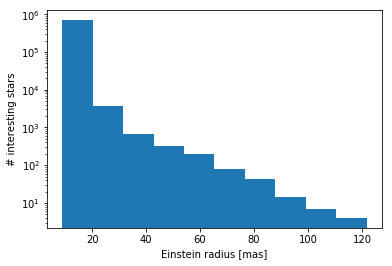

In [13]:
plt.hist(theta_E.value)
plt.yscale('log')
plt.xlabel('Einstein radius [mas]')
plt.ylabel('# interesting stars')
plt.show()

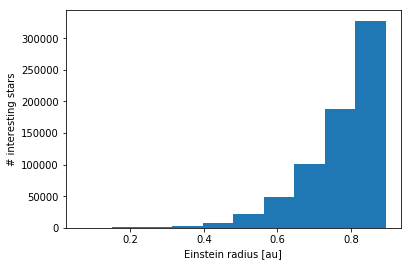

In [14]:
plt.hist(r_E.value)
plt.yscale('linear')
plt.xlabel('Einstein radius [au]')
plt.ylabel('# interesting stars')
plt.show()

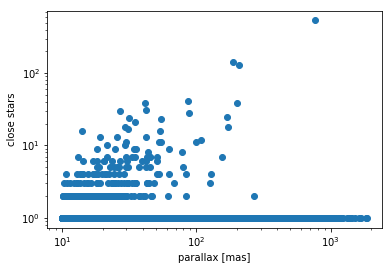

In [15]:
plt.scatter(s['parallax'],Nclose)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('parallax [mas]')
plt.ylabel('close stars')

plt.show()

In [16]:

time = np.linspace(0,deltaT,num=nt)

# only interested in alignments from start of this year
# this will also hopefully cut out the annoying duplicated sources
tStart = 3.0
earlyIndex = time < tStart
lateIndex = time >= tStart

raNom = [None]*len(s)
decNom = [None]*len(s)
dRASourceNom = [None]*len(s)
dDecSourceNom = [None]*len(s)
dRALensNom = [None]*len(s)
dDecLensNom = [None]*len(s)
DminNom = [None]*len(s)
Dmin2015Nom = [None]*len(s)

HasAVeryClose = [False]*len(s)
R_E = [None]*len(s)
mag_factor = [None]*len(s)

Mstar = 1.0

vclose = []

for i in interesting:

    if Nclose[i] > 1:
    
    # recentre to nominal lens location
        dRASource = (results[i]['ra'] - s[i]['ra'])*np.cos(np.radians(s[i]['dec']))*3600
        dDecSource = (results[i]['dec'] - s[i]['dec'])*3600
    
    # get alignments, distances, magnifications

        lensNom = np.zeros([len(results[i]),2,nt])
        sourceNom = np.zeros([len(results[i]),2,nt])
        distanceNom = []
        R_ENom  = []
        mag_factorNom = []
    
        DminNom[i] = np.zeros(len(results[i]))
        Dmin2015Nom[i] = np.zeros(len(results[i]))
    
        for j in range(len(results[i])):
            
# set NaN fields to 0 for pm, parallax and their errors            
            if math.isnan(results[i][j]['parallax']):
                results[i][j]['parallax'] = 0
            if math.isnan(results[i][j]['parallax_error']):
                results[i][j]['parallax_error'] = 0
            if math.isnan(results[i][j]['pmra']):
                results[i][j]['pmra'] = 0
            if math.isnan(results[i][j]['pmra_error']):
                results[i][j]['pmra_error'] = 0
            if math.isnan(results[i][j]['pmdec']):
                results[i][j]['pmdec'] = 0
            if math.isnan(results[i][j]['pmdec_error']):
                results[i][j]['pmdec_error'] = 0
    
            lens, source, distance, R_E, mag_factor = get_alignments(np.array([[0,0,s[i]['pmra'],s[i]['pmdec'],
                                                                                s[i]['parallax']]]),
                                                                     np.array([[dRASource[j],dDecSource[j],
                                                                                results[i][j]['pmra'],
                                                                                results[i][j]['pmdec'],
                                                                                results[i][j]['parallax']]]),
                                                                     time,Mstar,Earth,s[i]['ra'],s[i]['dec'])
        
            lensNom[j,:,:] = lens
            sourceNom[j,:,:] = source
            distanceNom.append(distance)
            R_ENom.append(R_E)
            mag_factorNom.append(mag_factor)
    
            Dmin2015Nom[i][j] = np.min(distance[:,earlyIndex])
            DminNom[i][j] = np.min(distance[:,lateIndex])
            if HasAVeryClose[i] == False:
                if DminNom[i][j] < 0.1 and DminNom[i][j] < Dmin2015Nom[i][j]:
                    vclose.append(i)
                    HasAVeryClose[i] = True
                    
    if HasAVeryClose[i]:
        print(i,DminNom[i])

25381 [0.         0.00462618]
33391 [0.         0.07888315]
40759 [0.         0.05109783]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

73764 [0.         0.09219238]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

81307 [ 0.         14.86196603 15.01325802 30.59191184  0.09745073 34.60410187
 27.74981983  7.2060511  38.99350398 42.65912005 43.95674694 23.72791831
 52.59868096 33.02466466  4.36723233 54.23889472 30.92305905 53.0793727 ]
88423 [0.00000000e+00 1.19370279e+01 8.83213692e+00 2.08051788e+01
 1.78939819e+01 8.21322094e-03]
102950 [0.         0.00612168]
110098 [0.         0.07605409 5.43275841 9.08803481]
139383 [0.         0.03487384]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

154971 [0.         0.02232351]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

168188 [0.         0.04825559]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

178953 [0.         0.08387433]
183178 [0.         0.02945595]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

246756 [0.         0.02049469]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

266940 [0.         0.02752445 6.31644347 5.53390689 4.59037207]
267600 [0.         0.00672781 1.80301046]
268072 [0.         0.06099301]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

293704 [0.         0.06678651]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

379500 [0.         0.03055644 5.6053611 ]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

388268 [0.         2.02094061 0.6367586  3.68636334 0.03887504 0.61653328]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

411719 [0.         0.04179409 3.79630489 6.11988511 4.18160515 0.41425982
 3.05341623 8.49823737 8.032985   6.0471567  8.25860204 8.90731884
 9.05402069 6.67987827 9.83998578 5.15731623]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

447529 [0.00000000e+00 3.65313334e+00 3.88783332e+00 2.12116146e+00
 1.39332600e+01 6.74993277e-03 1.67809292e+01 1.39139029e+01
 2.06556401e+01 1.55257077e+01 2.14752303e+01]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

452660 [ 0.          4.20502034  0.09921547  4.29360969  0.9215291   4.64401824
  6.55458795  7.14559514  8.69042027  1.72653278  6.90206953  8.72211797
  2.51061627  8.72605851  7.35658767  9.76958499  6.64117201  9.38515569
  8.44817765  5.56811698 10.93747211  0.35391041  9.75036383 11.85070415
  7.63036769 12.07208551  8.39558724  3.2573368   4.84215765 11.19178089
  5.27490715]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

541014 [0.        0.0038282]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

558936 [0.         0.04874477]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

558947 [ 0.          5.72201777 11.64620235 12.24708475 12.33340464 23.37813336
 26.7883553  30.70144681 35.16590269 33.44819345 19.88558564 39.10799432
 41.92053241 43.79211707 20.94922951 17.57062315 39.61453694 23.75061335
 51.37398602 57.65639334 39.27771681 55.09421708 58.96509517 58.10603731
  0.06790664]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

594424 [ 0.          8.2756946   1.07420345 13.78758213 15.23115626  0.07898978
 12.48486861]
604605 [0.         0.05214665]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

625993 [0.         2.45775773 0.00289556]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: U

687770 [0.         2.11641336 5.28846724 0.04953429]


/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Warning: converting a masked element to nan.


In [17]:
# this is a list of lenses that approach within 0.1 arcsec of a potential background source

for i in range(len(s)):
    if HasAVeryClose[i]:
        print(i,s[i]['source_id'],s[i]['phot_g_mean_mag'],min(DminNom[i][1:]))

25381 318399257231042304 17.267206 0.004626181578003623
33391 4744453460527256448 16.913425 0.07888314548618576
40759 116048577524991872 15.457286 0.0510978276439978
73764 4612462518451692672 16.420473 0.09219237807823398
81307 3340477717172813568 10.099132 0.09745073201094998
88423 3425318817510655360 16.146029 0.008213220937478425
102950 2934637564368867072 15.492523 0.006121684919870069
110098 5613074690219333504 16.04412 0.0760540933033924
139383 5529180853514968960 14.770331 0.034873838624001174
154971 5411468169440274560 16.606663 0.022323513650452667
168188 5232662289996360448 15.571764 0.04825558924494584
178953 5237644830027339904 16.87358 0.08387432980202288
183178 5191076183243196160 16.439877 0.029455952859199993
246756 5846206202262355712 16.988401 0.020494688892991463
266940 5901094750438455808 16.610233 0.027524452710875384
267600 5903487940560263936 14.631079 0.006727810348981954
268072 5800510224109658240 17.724245 0.06099301478722783
293704 5819622622435541888 16.8299

In [18]:
# many of these will be physical binaries, so we need to cut out objects with similar parallax and pm
#(within 10%)

interesting2 = []

#uncomment these if you don't want to cut on them
pmrarel = 1
pmdecrel = 1

for i in interesting:
    good = 0
    for j in range(len(results[i])):
        prel = abs((s[i]['parallax'] - results[i][j]['parallax'])/s[i]['parallax'])
#        pmrarel = abs((s[i]['pmra'] - results[i][j]['pmra'])/s[i]['pmra'])
#        pmdecrel = abs((s[i]['pmdec']-results[i][j]['pmdec'])/s[i]['pmdec'])
        if (good == 0 and DminNom[i][j] < 1 and DminNom[i][j] < Dmin2015Nom[i][j] and 
            prel > 0.1):# and pmrarel > 0.1 and pmdecrel > 0.1):
            interesting2.append(i)
            good = 1
        
print(len(interesting2))
print(interesting2)

262
[2610, 4862, 5565, 6087, 18812, 20762, 23900, 25237, 25381, 26772, 29865, 30019, 33391, 36762, 40759, 43686, 46021, 59286, 63138, 72490, 73029, 73764, 76083, 77750, 78921, 81307, 82538, 82580, 85919, 86194, 88423, 95377, 97244, 97829, 100919, 102950, 108599, 109302, 109312, 109355, 110098, 111133, 112938, 112968, 116762, 122072, 122121, 129273, 137280, 137584, 139383, 140403, 149167, 151232, 152847, 153585, 153653, 154616, 154971, 158867, 160354, 161040, 163445, 164301, 164630, 165775, 166581, 167411, 168188, 168564, 168822, 170615, 171688, 176401, 178826, 178876, 178953, 183178, 189701, 192222, 199517, 199882, 203524, 212116, 216785, 220528, 221328, 221654, 222105, 226301, 226346, 235622, 246229, 246756, 247353, 250319, 253322, 254744, 254892, 255283, 258136, 259309, 264302, 266940, 267600, 268072, 275857, 276120, 276202, 276721, 279461, 281189, 282025, 282184, 284151, 287144, 287221, 292219, 293251, 293704, 294720, 295157, 304622, 307737, 308740, 309909, 319438, 325297, 326382, 3

In [ ]:
tmp = []

for i in range(len(Nclose)):
    if Nclose[i] > 1:
        tmp.append(i)
print(tmp)

In [21]:
s[vclose]

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
1635721458409799680,Gaia DR2 318399257231042304,318399257231042304,590266299,2015.5,26.523773985471298,0.14153063133820176,35.75243359045485,0.12474298660085593,17.79435336498298,0.17701739483852547,100.52319,88.24806986722596,0.280493271101207,-174.10817774989616,0.23023070295684417,-0.014083483,0.43069765,-0.08287913,0.16084258,-0.373251,0.0065012816,0.112671755,0.15268104,0.3116943,0.28721932,121,0,120,1,5.070752,209.32169,0.5796843024722974,5.205720229867298,31,False,1.2676108,1.0899233588895152,0.03393653733391496,-0.009150566,14,10,0.26513734,0,14,False,120,2335.950786726121,3.581905922656356,652.153,17.267206,14,210.0389067386758,16.162819388339415,12.99519,19.545639,14,3736.503589312089,19.64290672122109,190.22153,15.830756,1.6894802,0,3.7148829,2.2784328,1.43645,--,--,0,--,--,--,NOT_AVAILABLE,135.22780193691835,-25.810894257481475,37.88246828375186,23.073441597384587,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=318399257231042304,--
1635721458409799680,Gaia DR2 4744453460527256448,4744453460527256448,147491033,2015.5,35.036112334526244,0.060751333221739874,-51.9289018020667,0.061251142998611834,12.158008853162626,0.07631426834727988,159.31502,269.15401627

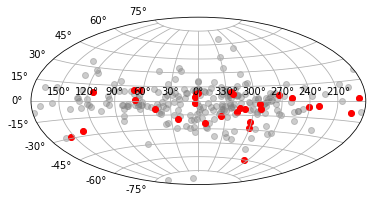

In [20]:
ax = plt.subplot(111,projection='aitoff')

l = np.radians(s[interesting2]['l'])
l[l > np.pi] -= 2. * np.pi
b = np.radians(s[interesting2]['b'])

plt.scatter(-l,b,c='grey',alpha=0.4)

l = np.radians(s[vclose]['l'])
l[l > np.pi] -= 2. * np.pi
b = np.radians(s[vclose]['b'])

plt.scatter(-l,b,c='r')

plt.grid(True)

ax.set_xticklabels(['150°','120°','90°','60°','30°','0°','330°','300°','270°','240°','210°'])

plt.savefig('aitoff.pdf')